# Testing Regression on Attractiveness Data

## Firstly, Regression Without Gender Stratification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Retrieve Data

In [2]:
train_txt = "data/regression_train_test/train_ratings.txt"
test_txt = "data/regression_train_test/test_ratings.txt"

with open(train_txt) as train_ratings:
    train_ratings = train_ratings.readlines()[0]
    train_ratings = np.array(train_ratings.split())
    train_ratings = train_ratings.astype(float)

with open(test_txt) as test_ratings:
    test_ratings = test_ratings.readlines()[0]
    test_ratings = np.array(test_ratings.split())
    test_ratings = test_ratings.astype(float)

print(train_ratings)
print(test_ratings)

[3.433333 2.9      3.966667 ... 3.05     2.4      2.666667]
[2.333333 3.45     2.7      ... 2.533333 4.433333 3.05    ]


In [3]:
img_width = 224
img_height = 224

In [4]:
import PIL

def image_to_tensor(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

In [5]:
import pathlib

train_dir = pathlib.Path("data/regression_train_test/train")
test_dir = pathlib.Path("data/regression_train_test/test")

train_images = list(train_dir.glob("*.jpg"))
test_images = list(test_dir.glob("*.jpg"))

x_train = np.array([image_to_tensor(impath) for impath in train_images])
y_train = train_ratings

x_test = np.array([image_to_tensor(impath) for impath in test_images])
y_test = test_ratings

### Make and Train Model

In [6]:
base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [8]:
history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40


  7/104 [=>............................] - ETA: 6:02 - loss: 7.9769 - mean_absolute_error: 2.6980

KeyboardInterrupt: 

In [9]:
def plot_reg_history(history):
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
plot_reg_history(history)

In [ ]:
model.save("models/45_resnet_regression_1")

## Regression with Gender Stratification

In [10]:
img_height = 224
img_width = 224

### Retrieve Data

In [11]:
# Just so that the img_height & img_width update
def image_to_tensor(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

In [12]:
def extract_ratings(text_path):
    with open(text_path) as ratings:
        ratings = ratings.readlines()[0]
        ratings = np.array(ratings.split())
        ratings = ratings.astype(float)

    return ratings

In [14]:
m_train_txt = "data/gender_split_regression/m_train_ratings"
f_train_txt = "data/gender_split_regression/f_train_ratings"

m_train_ratings = extract_ratings(m_train_txt)
f_train_ratings = extract_ratings(f_train_txt)

In [15]:
m_test_txt = "data/gender_split_regression/m_test_ratings"
f_test_txt = "data/gender_split_regression/f_test_ratings"

m_test_ratings = extract_ratings(m_test_txt)
f_test_ratings = extract_ratings(f_test_txt)

In [16]:
m_train_dir = pathlib.Path("data/gender_split_regression/m_train")
f_train_dir = pathlib.Path("data/gender_split_regression/f_train")
m_test_dir = pathlib.Path("data/gender_split_regression/m_test")
f_test_dir = pathlib.Path("data/gender_split_regression/f_test")

m_train_images = list(m_train_dir.glob("*.jpg"))
f_train_images = list(f_train_dir.glob("*.jpg"))
m_test_images = list(m_test_dir.glob("*.jpg"))
f_test_images = list(f_test_dir.glob("*.jpg"))

m_x_train = np.array([image_to_tensor(impath) for impath in m_train_images])
m_y_train = m_train_ratings

f_x_train = np.array([image_to_tensor(impath) for impath in f_train_images])
f_y_train = f_train_ratings

m_x_test = np.array([image_to_tensor(impath) for impath in m_test_images])
m_y_test = m_test_ratings

f_x_test = np.array([image_to_tensor(impath) for impath in f_test_images])
f_y_test = f_test_ratings

### Training Male Model

In [103]:
m_base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
m_base_model.trainable = False

m_model = tf.keras.Sequential([
    m_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

m_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [104]:
m_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [105]:
m_history = m_model.fit(m_x_train, m_y_train, batch_size=32, epochs=10, validation_data=(m_x_test, m_y_test))

Epoch 1/10
51/51 [==============================] - 302s 6s/step - loss: 0.8675 - mean_absolute_error: 0.7206 - val_loss: 0.4048 - val_mean_absolute_error: 0.5184
Epoch 2/10
51/51 [==============================] - 290s 6s/step - loss: 0.4249 - mean_absolute_error: 0.5202 - val_loss: 0.3925 - val_mean_absolute_error: 0.5011
Epoch 3/10
51/51 [==============================] - 290s 6s/step - loss: 0.4176 - mean_absolute_error: 0.5118 - val_loss: 0.4006 - val_mean_absolute_error: 0.4779
Epoch 4/10
51/51 [==============================] - 290s 6s/step - loss: 0.4094 - mean_absolute_error: 0.5043 - val_loss: 0.3775 - val_mean_absolute_error: 0.4856
Epoch 5/10
51/51 [==============================] - 297s 6s/step - loss: 0.3981 - mean_absolute_error: 0.4968 - val_loss: 0.3702 - val_mean_absolute_error: 0.4795
Epoch 6/10
51/51 [==============================] - 292s 6s/step - loss: 0.3950 - mean_absolute_error: 0.4942 - val_loss: 0.3848 - val_mean_absolute_error: 0.5183
Epoch 7/10
51/51 [====

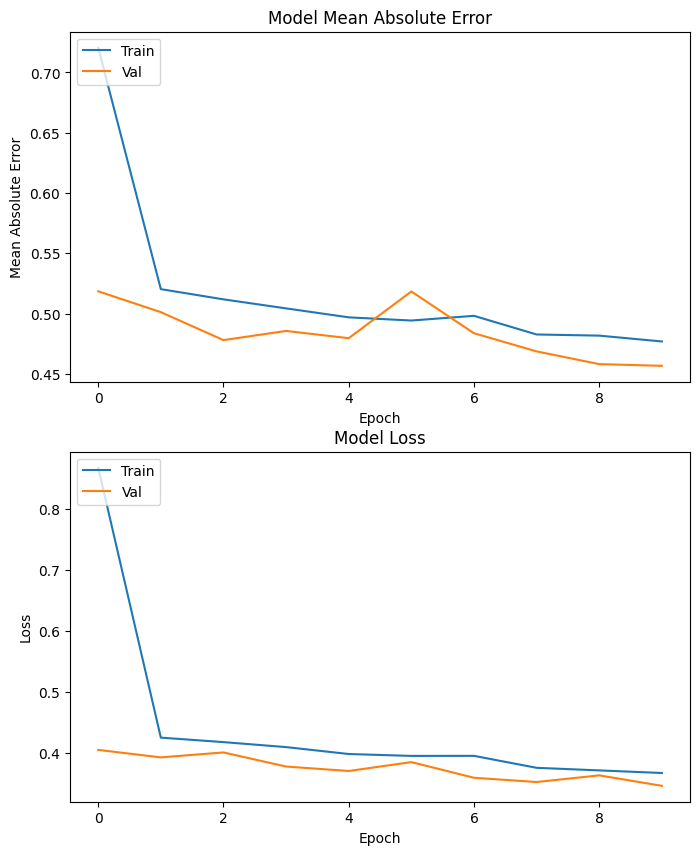

In [106]:
plot_reg_history(m_history)

In [107]:
def predict_male(impath):
    img = tf.keras.utils.load_img(impath, target_size=(img_width, img_height))
    #img_array = tf.keras.utils.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0)
    img_array = np.array([image_to_tensor(impath)])
    prediction = m_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")

    return img

1/1 [==============================] - 0s 221ms/step
This person is most likely a 2.82


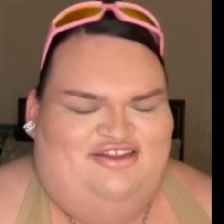

In [118]:
pred_path = "data/my_images/gorlock.jpg"

img = predict_male(pred_path)
img

### Training Female Model

In [109]:
f_base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
f_base_model.trainable = False

f_model = tf.keras.Sequential([
    f_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

f_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [110]:
f_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [111]:
f_history = f_model.fit(f_x_train, f_y_train, batch_size=32, epochs=10, validation_data=(f_x_test, f_y_test))

Epoch 1/10
53/53 [==============================] - 299s 6s/step - loss: 0.8729 - mean_absolute_error: 0.7484 - val_loss: 0.4938 - val_mean_absolute_error: 0.5857
Epoch 2/10
53/53 [==============================] - 290s 6s/step - loss: 0.4997 - mean_absolute_error: 0.5890 - val_loss: 0.4846 - val_mean_absolute_error: 0.5813
Epoch 3/10
53/53 [==============================] - 290s 6s/step - loss: 0.4866 - mean_absolute_error: 0.5828 - val_loss: 0.4796 - val_mean_absolute_error: 0.5765
Epoch 4/10
53/53 [==============================] - 290s 6s/step - loss: 0.4812 - mean_absolute_error: 0.5790 - val_loss: 0.4875 - val_mean_absolute_error: 0.5761
Epoch 5/10
53/53 [==============================] - 290s 6s/step - loss: 0.4742 - mean_absolute_error: 0.5746 - val_loss: 0.4680 - val_mean_absolute_error: 0.5699
Epoch 6/10
53/53 [==============================] - 290s 6s/step - loss: 0.4688 - mean_absolute_error: 0.5697 - val_loss: 0.4611 - val_mean_absolute_error: 0.5654
Epoch 7/10
53/53 [====

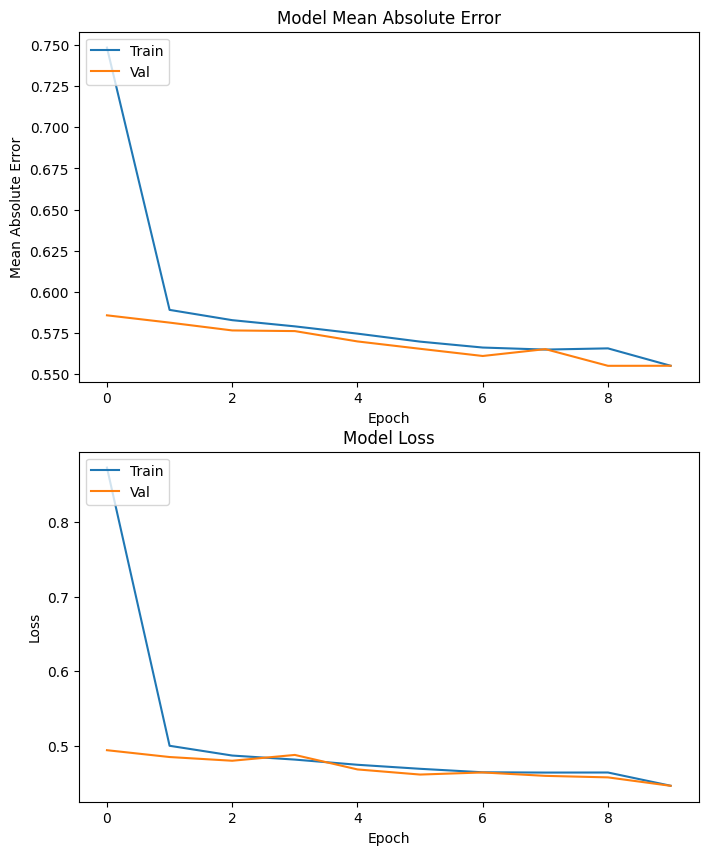

In [112]:
plot_reg_history(f_history)

In [113]:
def predict_female(impath):
    img = tf.keras.utils.load_img(impath, target_size=(img_width, img_height))
    #img_array = tf.keras.utils.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0)
    img_array = np.array([image_to_tensor(impath)])
    prediction = f_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")

    return img

1/1 [==============================] - 4s 4s/step
This person is most likely a 3.15
Actual rating: 3.266667


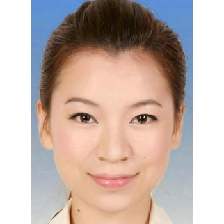

In [114]:
path = pathlib.Path(r"data\gender_split_regression\f_test\AF1471.jpg")
index = f_test_images.index(path)

f_actual_rating = f_test_ratings[index]
f_img = predict_female(path)
print(f"Actual rating: {f_actual_rating}")
f_img

1/1 [==============================] - 0s 222ms/step
This person is most likely a 3.19


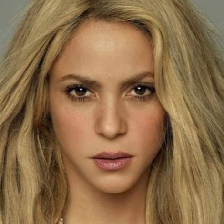

In [122]:
f_img = predict_female("data/my_images/shakira.jpg")
f_img

## Towards Data Science Model

In [130]:
img_width = 350
img_height = 350

def image_to_tensor(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

In [132]:
train_dir = pathlib.Path("data/regression_train_test/train")
test_dir = pathlib.Path("data/regression_train_test/test")

train_images = list(train_dir.glob("*.jpg"))
test_images = list(test_dir.glob("*.jpg"))

x_train = np.array([image_to_tensor(impath) for impath in train_images])
y_train = train_ratings

x_test = np.array([image_to_tensor(impath) for impath in test_images])
y_test = test_ratings

In [127]:
resnet = tf.keras.applications.ResNet50(include_top=False, pooling="avg")
tds_model = tf.keras.Sequential()
tds_model.add(resnet)
tds_model.add(tf.keras.layers.Dense(1))
tds_model.layers[0].trainable = False

tds_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [134]:
tds_model.compile(loss='mean_squared_error', optimizer="adam", metrics=["MeanAbsoluteError"])

In [135]:
tds_model.fit(batch_size=32, x=x_train, y=y_train, epochs=30)

Epoch 1/30
104/104 [==============================] - 395s 4s/step - loss: 0.5137 - mean_absolute_error: 0.5878
Epoch 2/30
104/104 [==============================] - 386s 4s/step - loss: 0.4602 - mean_absolute_error: 0.5577
Epoch 3/30
104/104 [==============================] - 376s 4s/step - loss: 0.4579 - mean_absolute_error: 0.5539
Epoch 4/30
104/104 [==============================] - 398s 4s/step - loss: 0.4517 - mean_absolute_error: 0.5486
Epoch 5/30
104/104 [==============================] - 396s 4s/step - loss: 0.4411 - mean_absolute_error: 0.5381
Epoch 6/30
104/104 [==============================] - 394s 4s/step - loss: 0.4327 - mean_absolute_error: 0.5367
Epoch 7/30
104/104 [==============================] - 378s 4s/step - loss: 0.4159 - mean_absolute_error: 0.5236
Epoch 8/30
104/104 [==============================] - 358s 3s/step - loss: 0.4086 - mean_absolute_error: 0.5187
Epoch 9/30
104/104 [==============================] - 357s 3s/step - loss: 0.4068 - mean_absolute_error: